In [21]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
rootDir_I = 'L:/DATA/Alouette_I/BATCH_I_Run2/'
resultDir_I = rootDir_I + '05_result/'
logDir_I = rootDir_I + '06_log/'

In [3]:
rootDir_II = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
resultDir_II = rootDir_II + '05_result/'
logDir_II = rootDir_II + '06_log/'

In [4]:
rootDir_tot = 'L:/DATA/Alouette_I/Total/'
resultDir_tot = rootDir_tot + '05_result/'
logDir_tot = rootDir_tot + '06_log/'

## Num Category

In [5]:
#Total Number of Num Categories
df_I = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_I = df_I[df_I['processed_image_class']=='num']
total_df_I = len(filter_df_I)
print ('Total number of NUM Ionograms in Batch I:', total_df_I)

df_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_II = df_II[df_II['processed_image_class']=='num']
total_df_II = len(filter_df_II)
print ('Total number of NUM Ionograms in Batch II :', total_df_II)

Total_num = total_df_I + total_df_II #combining Batch I and Batch II num data
print ('Total number of NUM Ionograms in both batches:', Total_num)

Total number of NUM Ionograms in Batch I: 465009
Total number of NUM Ionograms in Batch II : 114045
Total number of NUM Ionograms in both batches: 579054


### Batch I

Number of Images Analyzed in BATCH I: 49
Number of "year" element categorized correctly: 48
Percent reading accuracy of the "year" element:  97.95918367346938
Standard Error for "year" element: 0.02019884323695485
Number of "Day_1" element categorized correctly: 48
Percent reading accuracy of the "Day_1" element:  97.95918367346938
Standard Error for "Day_1" element: 0.02019884323695485
Number of "Day_2" element categorized correctly: 48
Percent reading accuracy of the "Day_2" element:  97.95918367346938
Standard Error for "Day_2" element: 0.02019884323695485
Number of "Day_3" element categorized correctly: 48
Percent reading accuracy of the "Day_3" element:  97.95918367346938
Standard Error for "Day_3" element: 0.02019884323695485
Number of "Hour_1" element categorized correctly: 48
Percent reading accuracy of the "Hour_1" element:  97.95918367346938
Standard Error for "Hour_1" element: 0.02019884323695485
Number of "Hour_2" element categorized correctly: 48
Percent reading accuracy o

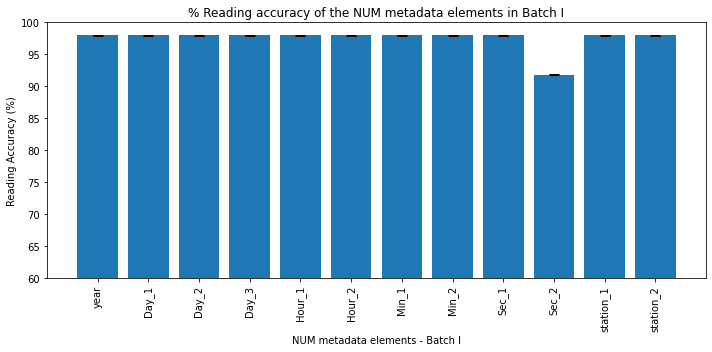

In [40]:
df_I = pd.read_csv("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_QA.csv") 
total_I = len(df_I)
print ('Number of Images Analyzed in BATCH I:', total_I)

categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
accuracy_data = []
for column in categorical_columns:
    col_sum = df_I[column].sum()
    accuracy_percent = (col_sum/total_I)*100
    p = accuracy_percent/100
    standard_error = np.sqrt(p*(1-p)/total_I)
    
    print(f'Number of "{column}" element categorized correctly:' , col_sum)
    print (f'Percent reading accuracy of the "{column}" element: ', accuracy_percent)
    print (f'Standard Error for "{column}" element:', standard_error)
    
    accuracy_data.append ((column, accuracy_percent,standard_error))
    
fig = plt.figure(figsize = (10, 5))
categories, accuracies, standard_error  = zip(*accuracy_data) 
plt.bar(categories, accuracies, yerr = standard_error, capsize = 5)
plt.ylim(60, 100)

plt.title ("% Reading accuracy of the NUM metadata elements in Batch I")
plt.xlabel("NUM metadata elements - Batch I")
plt.ylabel("Reading Accuracy (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [24]:
# BATCH I - Summary
df_I = df_I.loc[df_I['Issue'] != 'None'] 
filtered_down_I = len(df_I)
print('Number of Ionograms categorized correctly consistently:', total_I - filtered_down_I)

#BATCH I - Estimated success rate Batch I
success_rate = (total_I - filtered_down_I)/total_I 
Estimation = round(success_rate*total_df_I)
print('Estimated Success Rate out of BATCH I with 465,009 ionograms:', Estimation)

# Number of All categories error
df_I = df_I.loc[df_I['Issue'] == 'All categories']
filtered_down_I = len(df_I)
print('Number of incorrectly analyzed ionograms across all categories:', filtered_down_I)
print(df_I.loc[:,["Directory","Subdirectory", "filename"]])

Number of Ionograms categorized correctly consistently: 45
Estimated Success Rate out of BATCH I with 465,009 ionograms: 427049
Number of incorrectly analyzed ionograms across all categories: 1
     Directory Subdirectory       filename
3  R014207909F          713  Image0317.png


### Batch II

Number of Images Analyzed in BATCH II: 50
Number of "year" element categorized correctly: 45
Percent reading accuracy of the "year" element:  90.0
Standard Error for "year" element: 0.04242640687119285
Number of "Day_1" element categorized correctly: 46
Percent reading accuracy of the "Day_1" element:  92.0
Standard Error for "Day_1" element: 0.038366652186501746
Number of "Day_2" element categorized correctly: 46
Percent reading accuracy of the "Day_2" element:  92.0
Standard Error for "Day_2" element: 0.038366652186501746
Number of "Day_3" element categorized correctly: 45
Percent reading accuracy of the "Day_3" element:  90.0
Standard Error for "Day_3" element: 0.04242640687119285
Number of "Hour_1" element categorized correctly: 45
Percent reading accuracy of the "Hour_1" element:  90.0
Standard Error for "Hour_1" element: 0.04242640687119285
Number of "Hour_2" element categorized correctly: 45
Percent reading accuracy of the "Hour_2" element:  90.0
Standard Error for "Hour_2" elem

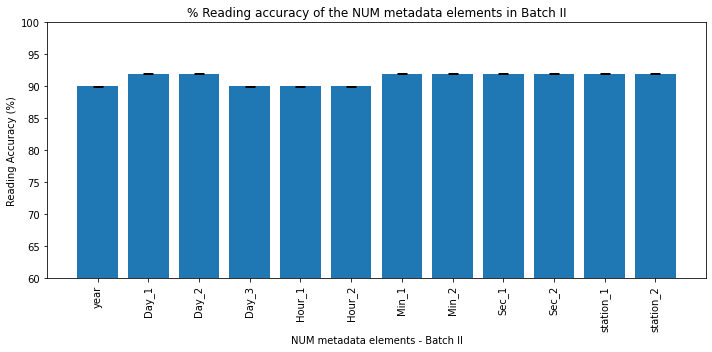

In [41]:
df_II = pd.read_csv("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_num.csv") 
total_II = len(df_II)
print ('Number of Images Analyzed in BATCH II:', total_II)

categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
accuracy_data = []
for column in categorical_columns:
    col_sum = df_II[column].sum()
    accuracy_percent = (col_sum/total_II)*100
    p = accuracy_percent/100
    standard_error = np.sqrt(p*(1-p)/total_II)
    
    print(f'Number of "{column}" element categorized correctly:' , col_sum)
    print (f'Percent reading accuracy of the "{column}" element: ', accuracy_percent)
    print (f'Standard Error for "{column}" element:', standard_error)
    
    accuracy_data.append ((column, accuracy_percent,standard_error))
    
fig = plt.figure(figsize = (10, 5))
categories, accuracies, standard_error  = zip(*accuracy_data) 
plt.bar(categories, accuracies, yerr = standard_error, capsize = 5)
plt.ylim(60, 100)

plt.title ("% Reading accuracy of the NUM metadata elements in Batch II")
plt.xlabel("NUM metadata elements - Batch II")
plt.ylabel("Reading Accuracy (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [42]:
# BATCH II - Summary
df_II = df_II.loc[df_II['Issue'] != 'None']
filtered_down_II = len(df_II)
print ('Batch II Summary:')
print('Total number of Ionograms categorized correctly consistently:', total_II - filtered_down_II)

#BATCH II - Estimated success rate
success_rate = (total_II - filtered_down_II)/total_II
Estimation = round(success_rate*total_df_II)
print('Estimated Success Rate of BATCH II with 123,975 ionograms:', Estimation)

# Number of All categories error
df_II = df_II.loc[df_II['Issue'] == 'All category']
filtered_down_II = len(df_II)
print('The "All Category" error is due to the number of NUM2 ionograms incorrectly categorized as Num data by the algorithm:', filtered_down_II)
print(df_II.loc[:,["Directory","Subdirectory", "filename"]])

Batch II Summary:
Total number of Ionograms categorized correctly consistently: 45
Estimated Success Rate of BATCH II with 123,975 ionograms: 102640
The "All Category" error is due to the number of NUM2 ionograms incorrectly categorized as Num data by the algorithm: 4
     Directory Subdirectory filename
11  R014207820      2979-5B  109.png
16  R014207825     3729-19A  105.png
44  R014207808      4575-50   14.png
49  R014207819      4757-15   77.png


### Total NUM category analysis

Total number of NUM Ionograms in BATCH I and II analyzed: 99
Total number of NUM Ionograms in BATCH II and II analyzed correctly:  94
Estimated Success Rate of Total NUM with 579,054 ionograms: 549809
Estimated Percent certainty: 94.94952111547455


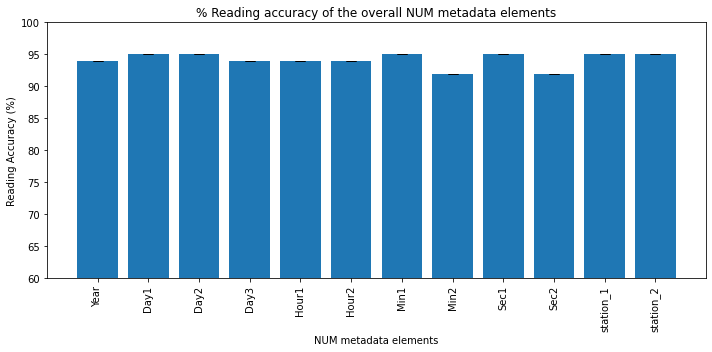

In [45]:
Image_total = total_I + total_II
print ('Total number of NUM Ionograms in BATCH I and II analyzed:', Image_total)

Correct_total = (total_I - filtered_down_I) + (total_II - filtered_down_II)
print ('Total number of NUM Ionograms in BATCH II and II analyzed correctly: ', Correct_total)

#Estimated success rate
success_rate = Correct_total/Image_total
Estimation = round(success_rate*Total_num)
print('Estimated Success Rate of Total NUM with 579,054 ionograms:', Estimation)

#Overall Percent certainty
percent_tot = Estimation*100/Total_num
print('Estimated Percent certainty:' , percent_tot)

#Percent certainty of  all num metadata elements
percent_tot_year = (percent_df_II_year + percent_df_I_year)/2
percent_tot_day1= (percent_df_II_Day1 + percent_df_I_Day1)/2
percent_tot_day2= (percent_df_II_Day2 + percent_df_I_Day2)/2
percent_tot_day3 = (percent_df_II_Day3 + percent_df_I_Day3)/2
percent_tot_hour1= (percent_df_II_Hour1 + percent_df_I_Hour1)/2
percent_tot_hour2= (percent_df_II_Hour2 + percent_df_I_Hour2)/2
percent_tot_min1 = (percent_df_II_min1 + percent_df_I_min1)/2
percent_tot_min2 = (percent_df_II_min2 + percent_df_II_min2)/2
percent_tot_sec1 = (percent_df_II_sec1 +percent_df_I_sec1)/2
percent_tot_sec2= (percent_df_II_sec2 + percent_df_I_sec2)/2
percent_tot_station_1 = (percent_df_II_station_1 + percent_df_I_station_1)/2
percent_tot_station_2 = (percent_df_II_station_2 + percent_df_I_station_2)/2

num_dataset = {'Year':percent_tot_year, 'Day1':percent_tot_day1, 'Day2': percent_tot_day2, 
                  'Day3': percent_tot_day3, 'Hour1':percent_tot_hour1, 'Hour2':percent_tot_hour2,
                  'Min1': percent_tot_min1, 'Min2':percent_tot_min2, 'Sec1':percent_tot_sec1,
                  'Sec2':percent_tot_sec2, 'station_1': percent_tot_station_1, 'station_2': percent_tot_station_2}
#standard error
standard_errors = {}
for element, percent in num_dataset.items():
    p = percent / 100
    standard_error = np.sqrt (p*(1-p)/Total_num)
    standard_errors [element] = standard_error
    
#Graphing the % reading accuracy of the elements
fig = plt.figure(figsize = (10, 5))
x = list(num_dataset.keys())
y = list(num_dataset.values())
plt.bar(x,y, yerr = list(standard_errors.values()), capsize = 5)
plt.ylim(60, 100)
plt.title ("% Reading accuracy of the overall NUM metadata elements")
plt.xlabel("NUM metadata elements")
plt.ylabel("Reading Accuracy (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Dot category

In [11]:
df_dot_I = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_dot_I = df_dot_I[df_dot_I['processed_image_class']=='dot']
total_df_dot_I= len(filter_df_dot_I)
print ('Total number of dot Ionograms in BATCH I:', total_df_dot_I)

df_dot_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_dot_II = df_dot_II[df_dot_II['processed_image_class']=='dot']
total_df_dot_II = len(filter_df_dot_II)
print ('Total number of dot Ionograms in BATCH II:', total_df_dot_II)

Total_dot = total_df_dot_I + total_df_dot_II  #combining Batch I and Batch II num data
print ('Total dot ionograms in Batch I and II: ', Total_dot)

Total number of dot Ionograms in BATCH I: 7784
Total number of dot Ionograms in BATCH II: 4481
Total dot ionograms in Batch I and II:  12265


Number of dot Ionograms Analyzed: 10
Number of ionograms categorized correctly: 0
Estimated Success Rate out of 7784 with consistent results: 0


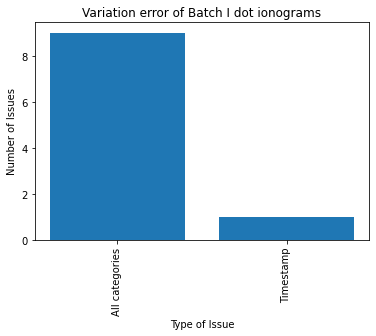

     Directory  Subdirectory       Filename
0  R014207940F           339  Image0150.png
1  R014207979F           394  Image0062.png
2  R014207929F           480  Image0242.png
3  R014207929F           476  Image0003.png
4  R014207907F           508      Image0119
6  R014207907F           512  Image0353.png
7  R014207979F           297  Image0206.png
8  R014207979F           291  Image0330.png
9  R014207940F           404  Image0224.png


In [12]:
#Batch I
df_dot_I = pd.read_csv("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_dot_QA.csv")
total_dot_I = len(df_dot_I)
print('Number of dot Ionograms Analyzed:', total_dot_I)

# filtering out correct categories
df_dot_I= df_dot_I.loc[df_dot_I['Issue'] != 'None']
filtered_down_dot_I = len(df_dot_I)
print('Number of ionograms categorized correctly:', total_dot_I - filtered_down_dot_I)

#Estimated success rate
success_rate = (total_dot_I - filtered_down_dot_I)/total_dot_I
Estimation = round(success_rate*total_df_dot_I)
print('Estimated Success Rate out of 7784 with consistent results:', Estimation)

#Plotting the variation of issues
issue_counts_dot_I = df_dot_I["Issue"].value_counts()
plt.bar(issue_counts_dot_I.index, issue_counts_dot_I.values)
plt.title ("Variation error of Batch I dot ionograms")
plt.xlabel("Type of Issue")
plt.ylabel("Number of Issues")
plt.xticks(rotation=90)
plt.show()

# Number of All categories error
df_dot_I = df_dot_I.loc[df_dot_I['Issue'] == 'All categories']
print(df_dot_I.loc[:,["Directory","Subdirectory", "Filename"]])


Number of Images Analyzed: 15
Number of Ionograms Analyzed correctly: 0
Estimated Success Rate out of 4481 with consistent results: 0.0


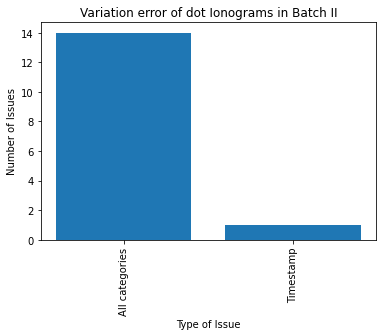

Number of NUM/NUM2 ionograms categorized as dot data by the algorithm: 14
     Directory Subdirectory filename
0   R014207961       1039-1  283.png
1   R014207961       1069-A  297.png
3   R014207944     1994-12A  131.png
4   R014207961       1076-A  288.png
5   R014207961       1039-1   19.png
6   R014207961       1069-A  263.png
7   R014207944      2042-3A  272.png
8   R014207961       1058-A  336.png
9   R014207961       1029-A  129.png
10  R014207961       1031-A  178.png
11  R014207944      2042-3A  125.png
12  R014207961       1031-A  154.png
13  R014207961       1076-A  158.png
14  R014207961       1065-A  231.png


In [13]:
#Batch II
df_dot_II = pd.read_csv("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_dot.csv")
total_dot_II = len(df_dot_II)
print ('Number of Images Analyzed:', total_dot_II)
filtered_down_dot_II = 0 #no ionogram was analyzed correctly
print('Number of Ionograms Analyzed correctly:',filtered_down_dot_II)

#Estimated success rate
success_rate = filtered_down_dot_II/total_dot_II
Estimation = success_rate*total_df_dot_II
print('Estimated Success Rate out of 4481 with consistent results:', Estimation)

#Plotting the variation of issues
issue_counts_dot_II = df_dot_II["Issue"].value_counts()
plt.bar(issue_counts_dot_II.index, issue_counts_dot_II.values)
plt.title ("Variation error of dot Ionograms in Batch II")
plt.xlabel("Type of Issue")
plt.ylabel("Number of Issues")
plt.xticks(rotation=90)
plt.show()

# filtering out correct categories
df_dot_II = df_dot_II.loc[df_dot_II['Issue'] == 'All categories']
filtered_down_dot_II = len(df_dot_II)
print('Number of NUM/NUM2 ionograms categorized as dot data by the algorithm:', filtered_down_dot_II)
print(df_dot_II.loc[:,["Directory","Subdirectory", "filename"]])

In [14]:
#Total Dot image analysis:
Image_total_dot = total_dot_I + total_dot_II
print ('Total number of DOT Ionograms in BATCH I and II analyzed:', Image_total_dot)

Correct_total_dot = (total_dot_I - filtered_down_dot_I) + (total_dot_II - filtered_down_dot_II)
print ('Total number of Dot Ionograms in BATCH II and II analyzed correctly: ', Correct_total_dot)

#Estimated success rate
Estimation  = round(Correct_total_dot*Image_total_dot/Total_dot)
print('Estimated Success Rate of Total Dot with 12,265 ionograms:', Estimation)

#Percent certaintly
percent_tot_dot = Estimation*100/Total_dot
print('Estimated Percent certainty:' , percent_tot_dot)

Total number of DOT Ionograms in BATCH I and II analyzed: 25
Total number of Dot Ionograms in BATCH II and II analyzed correctly:  1
Estimated Success Rate of Total Dot with 12,265 ionograms: 0
Estimated Percent certainty: 0.0


## NUM2 category

In [15]:
#Total Number of Num Categories
df_num2_1 = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_num2_1 = df_num2_1[df_num2_1['processed_image_class']=='num2']
total_df_num2_1 = len(filter_df_num2_1)
print ('Total number of NUM2 Ionograms in Batch I:', total_df_num2_1)

df_num2_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_num2_II = df_num2_II[df_num2_II['processed_image_class']=='num2']
total_df_num2_II = len(filter_df_num2_II)
print ('Total number of NUM2 Ionograms in Batch II :', total_df_num2_II)

df_num2_total = pd.read_csv(resultDir_tot + 'result_master.csv')
filter_df_total= df_num2_total[df_num2_total['processed_image_class']=='num2']
total_df_num2 = len(filter_df_total)
print('Total number of NUM2 Ionograms in both batches:', total_df_num2)

Total number of NUM2 Ionograms in Batch I: 38149
Total number of NUM2 Ionograms in Batch II : 87924
Total number of NUM2 Ionograms in both batches: 126073


### Batch I

Number of Images Analyzed in BATCH I: 15
Number of "year" element categorized correctly: 15
Percent reading accuracy of the "year" element:  100.0
Standard Error for "year" element: 0.0
Number of "Day_1" element categorized correctly: 15
Percent reading accuracy of the "Day_1" element:  100.0
Standard Error for "Day_1" element: 0.0
Number of "Day_2" element categorized correctly: 11
Percent reading accuracy of the "Day_2" element:  73.33333333333333
Standard Error for "Day_2" element: 0.11417984514369005
Number of "Day_3" element categorized correctly: 10
Percent reading accuracy of the "Day_3" element:  66.66666666666666
Standard Error for "Day_3" element: 0.12171612389003693
Number of "Hour_1" element categorized correctly: 14
Percent reading accuracy of the "Hour_1" element:  93.33333333333333
Standard Error for "Hour_1" element: 0.0644061188719531
Number of "Hour_2" element categorized correctly: 13
Percent reading accuracy of the "Hour_2" element:  86.66666666666667
Standard Error

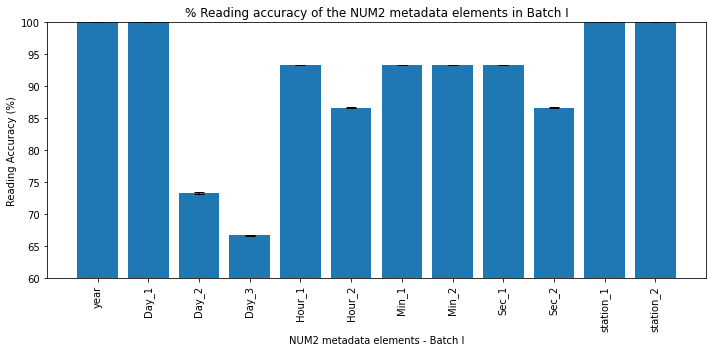

In [47]:
df_num2_I = pd.read_csv("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_num2_QA.csv") 
total_num2_I = len(df_num2_I)
print ('Number of Images Analyzed in BATCH I:', total_num2_I)
categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
accuracy_data = []
for column in categorical_columns:
    col_sum = df_num2_I[column].sum()
    accuracy_percent = (col_sum/total_num2_I)*100
    p = accuracy_percent/100
    standard_error = np.sqrt(p*(1-p)/total_num2_I)
    
    print(f'Number of "{column}" element categorized correctly:' , col_sum)
    print (f'Percent reading accuracy of the "{column}" element: ', accuracy_percent)
    print (f'Standard Error for "{column}" element:', standard_error)
    
    accuracy_data.append ((column, accuracy_percent,standard_error))
    
fig = plt.figure(figsize = (10, 5))
categories, accuracies, standard_error  = zip(*accuracy_data) 
plt.bar(categories, accuracies, yerr = standard_error, capsize = 5)
plt.ylim(60, 100)

plt.title ("% Reading accuracy of the NUM2 metadata elements in BatchI")
plt.xlabel("NUM2 metadata elements - Batch I")
plt.ylabel("Reading Accuracy (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [46]:
# BATCH I - Summary
df_num2_I  = df_num2_I.loc[df_num2_I ['Issue'] != 'None']
filtered_down_num2_I = len(df_num2_I)
print ('Batch I Summary:')
print('Total number of Ionograms categorized correctly consistently:', total_num2_I - filtered_down_num2_I)

#BATCH II - Estimated success rate
success_rate = (total_num2_I - filtered_down_num2_I)/total_num2_I
Estimation = round(success_rate*total_df_num2)
print('Estimated Success Rate of BATCH II with 126,073 ionograms:', Estimation)
# Number of All categories error
df_num2_I = df_num2_I.loc[df_num2_I['Issue'] == 'Day']
filtered_down_I = len(df_num2_I)
print('The algorithm reads Day_2 and Day_3 inccorectly with no clear pattern:', filtered_down_I)
print(df_num2_I.loc[:,["Directory","Subdirectory", "filename"]])

Batch I Summary:
Total number of Ionograms categorized correctly consistently: 10
Estimated Success Rate of BATCH II with 126,073 ionograms: 84049
The algorithm reads Day_2 and Day_3 inccorectly with no clear pattern: 5
     Directory Subdirectory filename
0   R014207816     3408-43A  285.png
1   R014207955     2843-50B  180.png
2   R014207824      3135-8A  258.png
9   R014207824     3174-14A  259.png
14  R014207841      3076-8A  236.png


###  Batch II

Number of Images Analyzed in BATCH II: 34
Number of "year" element categorized correctly: 33
Percent reading accuracy of the "year" element:  97.05882352941177
Standard Error for "year" element: 0.028976010768934652
Number of "Day_1" element categorized correctly: 34
Percent reading accuracy of the "Day_1" element:  100.0
Standard Error for "Day_1" element: 0.0
Number of "Day_2" element categorized correctly: 34
Percent reading accuracy of the "Day_2" element:  100.0
Standard Error for "Day_2" element: 0.0
Number of "Day_3" element categorized correctly: 34
Percent reading accuracy of the "Day_3" element:  100.0
Standard Error for "Day_3" element: 0.0
Number of "Hour_1" element categorized correctly: 34
Percent reading accuracy of the "Hour_1" element:  100.0
Standard Error for "Hour_1" element: 0.0
Number of "Hour_2" element categorized correctly: 34
Percent reading accuracy of the "Hour_2" element:  100.0
Standard Error for "Hour_2" element: 0.0
Number of "Min_1" element categorized 

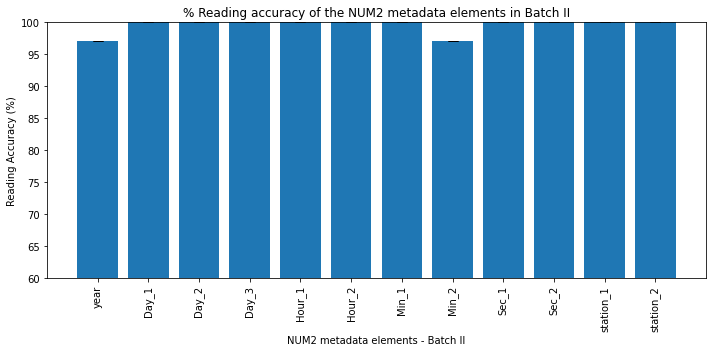

In [48]:
df_num2_II = pd.read_csv("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_num2.csv") 
total_num2_II = len(df_num2_II)
print ('Number of Images Analyzed in BATCH II:', total_num2_II)
categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
accuracy_data = []
for column in categorical_columns:
    col_sum = df_num2_II[column].sum()
    accuracy_percent = (col_sum/total_num2_II)*100
    p = accuracy_percent/100
    standard_error = np.sqrt(p*(1-p)/total_num2_II)
    
    print(f'Number of "{column}" element categorized correctly:' , col_sum)
    print (f'Percent reading accuracy of the "{column}" element: ', accuracy_percent)
    print (f'Standard Error for "{column}" element:', standard_error)
    
    accuracy_data.append ((column, accuracy_percent,standard_error))
    
fig = plt.figure(figsize = (10, 5))
categories, accuracies, standard_error  = zip(*accuracy_data) 
plt.bar(categories, accuracies, yerr = standard_error, capsize = 5)
plt.ylim(60, 100)

plt.title ("% Reading accuracy of the NUM2 metadata elements in Batch II")
plt.xlabel("NUM2 metadata elements - Batch II")
plt.ylabel("Reading Accuracy (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [49]:
# BATCH II - Summary
df_num2_II = df_num2_II.loc[df_num2_II ['Issue'] != 'None']
filtered_down_num2_II = len(df_num2_II)
print ('Batch II Summary:')
print('Total number of Ionograms categorized correctly consistently:', total_num2_II - filtered_down_num2_II)

#BATCH II - Estimated success rate
success_rate = (total_num2_II - filtered_down_num2_II)/total_num2_II
Estimation = round(success_rate*total_df_num2)
print('Estimated Success Rate of BATCH II with 126,073 ionograms:', Estimation)
# Number of All categories error
df_num2_II = df_num2_II.loc[df_num2_II['Issue'] == 'Minute']
filtered_down_II = len(df_num2_II)
print('The algorithm reads 1 as 7 or vice versa:', filtered_down_II)
print(df_num2_II.loc[:,["Directory","Subdirectory", "filename"]])

Batch II Summary:
Total number of Ionograms categorized correctly consistently: 31
Estimated Success Rate of BATCH II with 126,073 ionograms: 114949
The algorithm reads 1 as 7 or vice versa: 2
    Directory Subdirectory filename
5  R014207831      3949-5A  207.png
8  R014207833      4349-38  136.png


Total number of NUM2 Ionograms in BATCH I and II analyzed: 49
Total number of NUM2 Ionograms in BATCH II and II analyzed correctly:  42
Estimated Success Rate of Total NUM2 ionograms: 108063
Estimated Percent certainty: 85.7146256533913


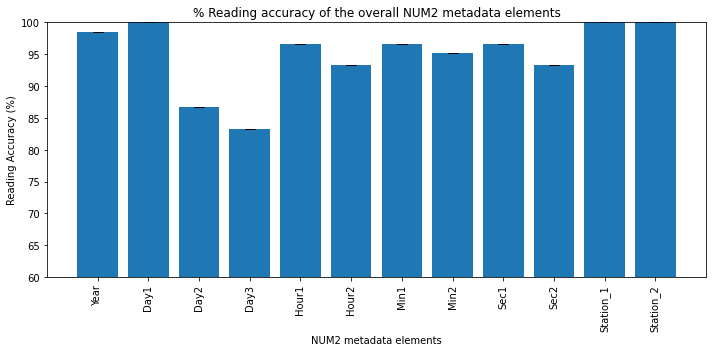

In [50]:
Image_total = total_num2_I + total_num2_II
print ('Total number of NUM2 Ionograms in BATCH I and II analyzed:', Image_total)

Correct_total = (total_num2_I - filtered_down_I) + (total_num2_II - filtered_down_II)
print ('Total number of NUM2 Ionograms in BATCH II and II analyzed correctly: ', Correct_total)

#Estimated success rate
success_rate = Correct_total/Image_total
Estimation = round(success_rate*total_df_num2)
print('Estimated Success Rate of Total NUM2 ionograms:', Estimation)

#Overall Percent certainty
percent_tot = Estimation*100/total_df_num2
print('Estimated Percent certainty:' , percent_tot)

#Percent certainty of  all num metadata elements
percent_tot_year = (percent_df_num2_I_year + percent_df_num2_II_year)/2
percent_tot_day1= (percent_df_num2_I_Day1 + percent_df_num2_II_Day1)/2
percent_tot_day2= (percent_df_num2_I_Day2 + percent_df_num2_II_Day2)/2
percent_tot_day3 = (percent_df_num2_I_Day3 + percent_df_num2_II_Day3)/2
percent_tot_hour1= (percent_df_num2_I_Hour1 + percent_df_num2_II_Hour1)/2
percent_tot_hour2= (percent_df_num2_I_Hour2 + percent_df_num2_II_Hour2)/2
percent_tot_min1 = (percent_df_num2_I_min1 + percent_df_num2_II_min1)/2
percent_tot_min2 = (percent_df_num2_I_min2+ percent_df_num2_II_min2)/2
percent_tot_sec1 = (percent_df_num2_I_sec1 + percent_df_num2_II_sec1)/2
percent_tot_sec2= (percent_df_num2_I_sec2+ percent_df_num2_II_sec2)/2
percent_tot_station1 = (percent_df_num2_I_station_1 + percent_df_num2_II_station_1)/2
percent_tot_station2 = (percent_df_num2_I_station_2 + percent_df_num2_II_station_2)/2

#Graphing the % reading accuracy of the elements
num2_dataset = {'Year':percent_tot_year, 'Day1':percent_tot_day1, 'Day2': percent_tot_day2, 
                  'Day3': percent_tot_day3, 'Hour1':percent_tot_hour1, 'Hour2':percent_tot_hour2,
                  'Min1': percent_tot_min1, 'Min2':percent_tot_min2, 'Sec1':percent_tot_sec1,
                  'Sec2':percent_tot_sec2, 'Station_1': percent_tot_station1, 'Station_2':percent_tot_station2 }
#standard error
standard_errors = {}
for element, percent in num2_dataset.items():
    p = percent / 100
    standard_error = np.sqrt (p*(1-p)/Total_num)
    standard_errors [element] = standard_error
    
#Graphing the % reading accuracy of the elements
fig = plt.figure(figsize = (10, 5))
x = list(num2_dataset.keys())
y = list(num2_dataset.values())
plt.bar(x,y, yerr = list(standard_errors.values()), capsize = 5)
plt.ylim(60, 100)
plt.title ("% Reading accuracy of the overall NUM2 metadata elements")
plt.xlabel("NUM2 metadata elements")
plt.ylabel("Reading Accuracy (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()